In [1]:
import pandas as pd
import numpy as np
import nltk, re
nltk.download('stopwords') # load english stopwords
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")
import _pickle as cPickle
import requests , json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
missing_values= ["['nan']"]

jobs_df = pd.read_csv('jobs_data.csv',na_values=missing_values)
jobs_df=jobs_df.dropna()
jobs_df=jobs_df.drop(['Unnamed: 0'], axis=1)
#jobs_df.keys()
jobs_df=jobs_df.reset_index(drop=True)

In [3]:
print (jobs_df['title'][:10])

0                          Full Stack PHP Developer
1           CISCO Collaboration Specialist Engineer
2                     Senior Back End-PHP Developer
3                                       UX Designer
4                               Java Technical Lead
5                        Technical Support Engineer
6                              Senior iOS Developer
7                               Mechanical Engineer
8    Real Estate Sales Specialist - 10th of Ramadan
9                                  School Principal
Name: title, dtype: object


In [4]:
#removing the unnecessary word after '-' like = "alex,10th ramadan"
for i in range(1, 1000): 
    text = jobs_df['title'][i]
    text = text.lower()
    if(' - ' in text):
        text=text.split(' - ')[:-1]
        text = " ".join(text)
        #print(text)
#print (jobs_df['title'][69])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(jobs_df['title'].values, jobs_df['jobFunction'].values, test_size=0.3, random_state=42)
jobs_df.head()

,title,jobFunction,industry
0,Full Stack PHP Developer,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Marketing and Advertisi..."
1,CISCO Collaboration Specialist Engineer,"['Installation/Maintenance/Repair', 'IT/Softwa...",['Information Technology Services']
2,Senior Back End-PHP Developer,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Computer Networking']"
3,UX Designer,"['Creative/Design/Art', 'IT/Software Developme...","['Computer Software', 'Information Technology ..."
4,Java Technical Lead,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Information Technology ..."


In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = list((stopwords.words('english')))

def text_prepare(text,join_sumbol):
    """
        text: a string
        
        return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text,)

    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = re.sub(r'\s+'," ",text)

    # delete stopwords from text
    text = "%s"%join_sumbol.join([i for i in text.split() if i not in STOPWORDS])
    
    return text

tests = ["~ئselected 1 ? \ por&ject $",
        "How to free c++ memory vector<int> * arr?"]
for test in tests: print(text_prepare(test,' '))

selected 1 porject
free c++ memory vectorint arr


In [7]:
X_train = [text_prepare(x,' ') for x in X_train]
X_test = [text_prepare(x,' ') for x in X_test]
y_train = [text_prepare(x,',') for x in y_train]
y_test = [text_prepare(x,',') for x in y_test]

In [8]:
from collections import Counter
from itertools import chain

# Dictionary of all tags from train corpus with their counts.
tags_counts = Counter(chain.from_iterable([i.split(",") for i in y_train]))

# Dictionary of all words from train corpus with their counts.
words_counts = Counter(chain.from_iterable([i.split(" ") for i in X_train]))

top_3_most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
top_3_most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print(f"Top three most popular tags are: {','.join(tag for tag, _ in top_3_most_common_tags)}")
print(f"Top three most popular words are: {','.join(tag for tag, _ in top_3_most_common_words)}")

Top three most popular tags are: engineering,development,software
Top three most popular words are: developer,senior,engineer


In [9]:

from sklearn.feature_extraction.text import TfidfVectorizer
import _pickle as cPickle

#def tf_vecto (X_train):
 #   return TfidfVectorizer(X_train,ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)' )


def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test — samples        
        return bag-of-words representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
   
    tfidf_vectorizer=TfidfVectorizer(X_train,ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)' )
    # tfidf_vectorizer = tf_vecto(X_train)
    tfidf_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    cPickle.dump(tfidf_vectorizer,open("TF_IDF_vecto.pkl","wb")) 
   

    return X_train, X_test, tfidf_vectorizer.vocabulary_



In [10]:
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [11]:
y_train = [set(i.split(',')) for i in y_train]
y_test = [set(i.split(',')) for i in y_test]

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.fit_transform(y_test)
X_train = mlb.fit_transform(y_train)
X_test = mlb.fit_transform(y_test)
cPickle.dump(mlb,open("mlb.pkl","wb"))

In [13]:
X_test

array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]])

# naive_bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

modelnb = MultinomialNB(alpha=0.01)
modelnb = OneVsRestClassifier(modelnb)
modelnb.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)

In [15]:
y_pred1 = modelnb.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(y_pred1,y_test)*100,"%")

accuracy :  58.7724736515809 %


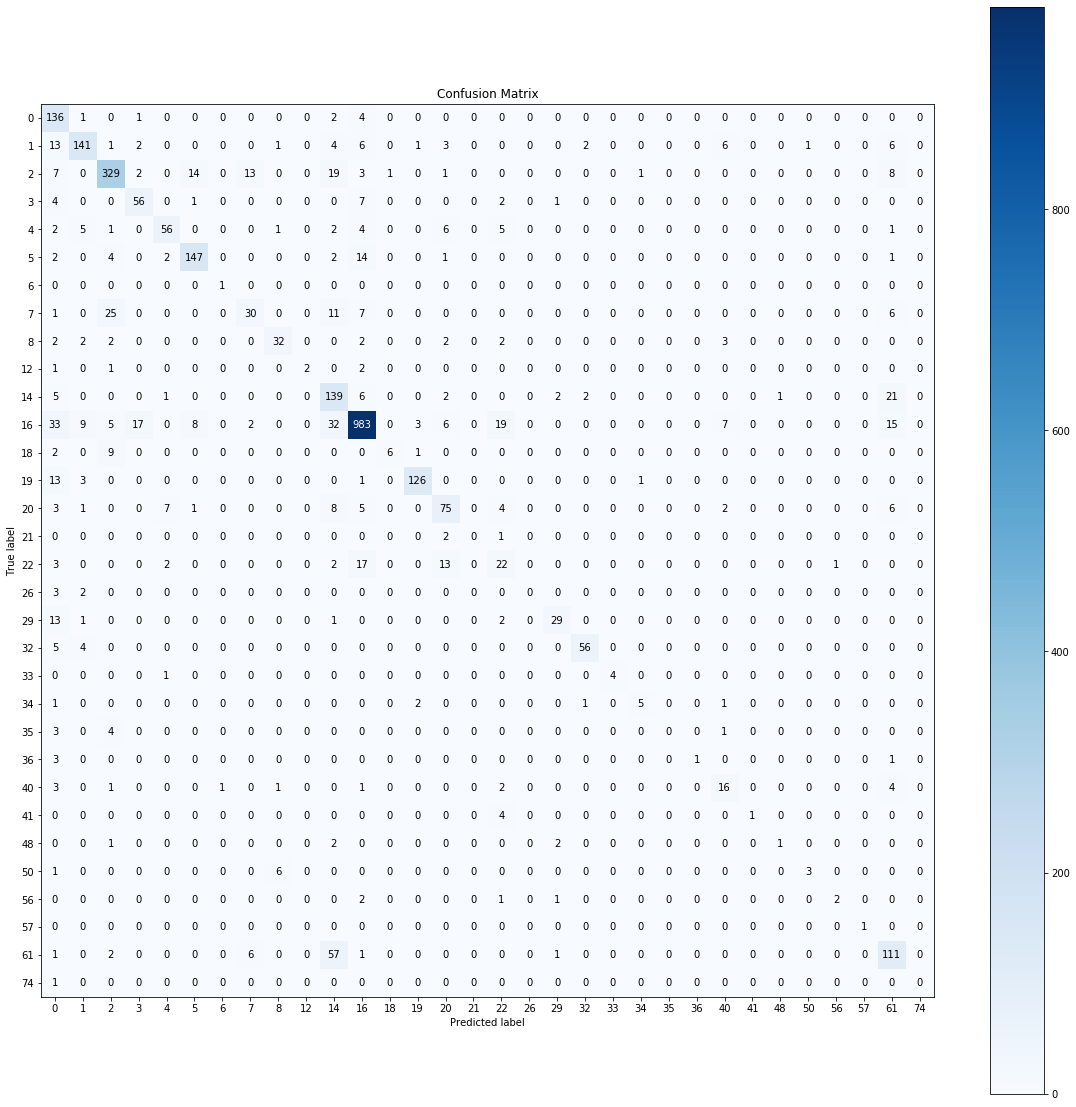

In [16]:
y_test1 = np.argmax(y_test, axis=1)
y_pred1 = np.argmax(y_pred1, axis=1)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
c = confusion_matrix(y_test1, y_pred1) 

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test1, 
    y_pred1,
    figsize=(20,20))

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_pred1, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.83      0.75      0.79       187
           2       0.85      0.83      0.84       398
           3       0.72      0.79      0.75        71

   micro avg       0.83      0.80      0.82       656
   macro avg       0.80      0.79      0.79       656
weighted avg       0.83      0.80      0.82       656



# LinearDiscriminantAnalysis

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
X_train_tfidf1 = X_train_tfidf.todense()
model_lda = LinearDiscriminantAnalysis(solver='svd')
model_lda = OneVsRestClassifier(model_lda)
model_lda.fit(X_train_tfidf1, y_train)

OneVsRestClassifier(estimator=LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                                                         shrinkage=None,
                                                         solver='svd',
                                                         store_covariance=False,
                                                         tol=0.0001),
                    n_jobs=None)

In [19]:
y_pred2 = model_lda.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(y_test,y_pred2)*100,'%')

accuracy :  64.10415375077496 %


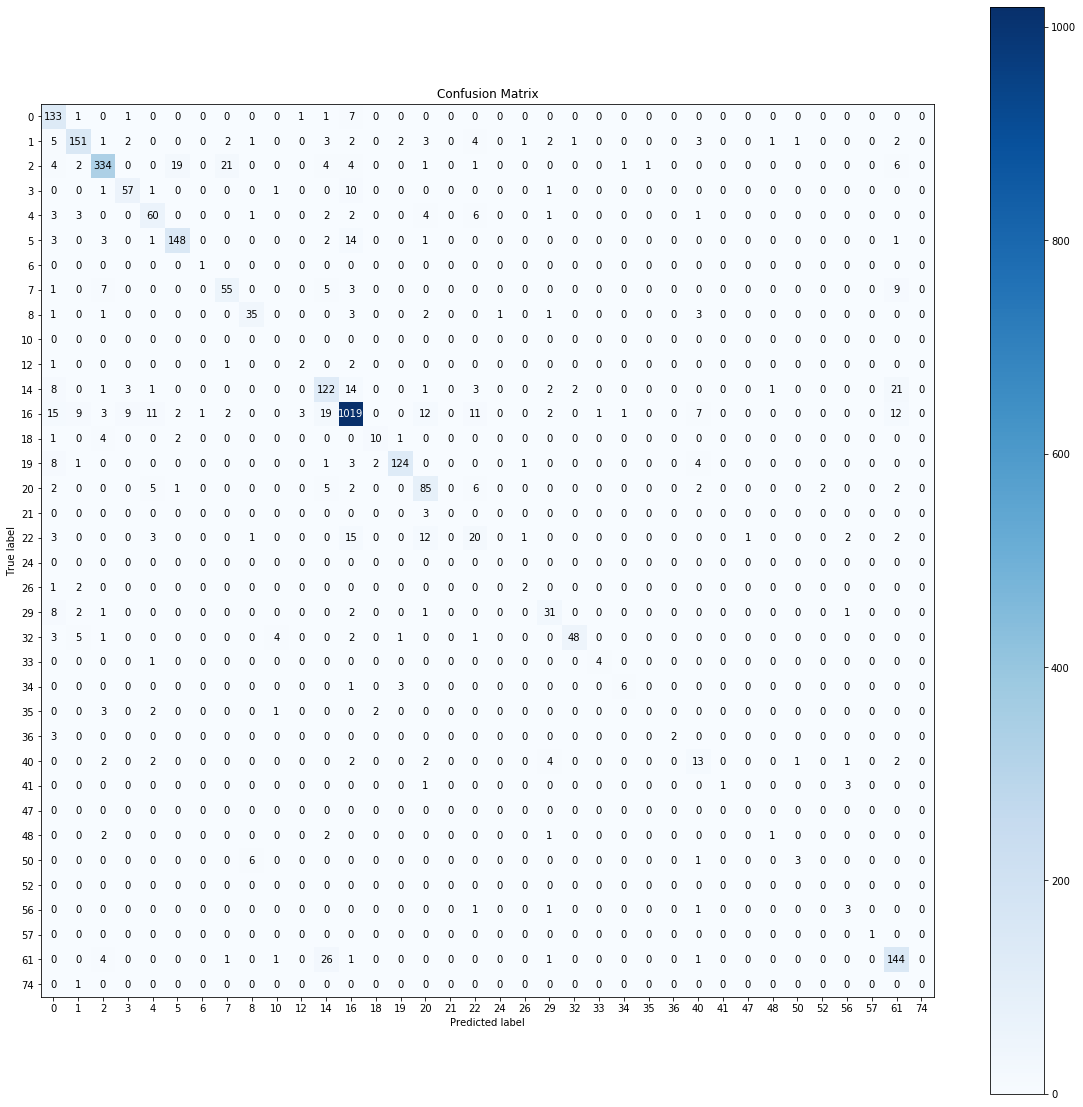

In [20]:
y_test2 = np.argmax(y_test, axis=1)
y_pred2 = np.argmax(y_pred2, axis=1)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
c = confusion_matrix(y_test2, y_pred2) 

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test2, 
    y_pred2,
    figsize=(20,20))

In [21]:
print(classification_report(y_test2, y_pred2, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.85      0.81      0.83       187
           2       0.91      0.84      0.87       398
           3       0.79      0.80      0.80        71

   micro avg       0.88      0.83      0.85       656
   macro avg       0.85      0.82      0.83       656
weighted avg       0.88      0.83      0.85       656



# SVM

In [22]:
X_train_tfidf

<7527x1189 sparse matrix of type '<class 'numpy.float64'>'
	with 34397 stored elements in Compressed Sparse Row format>

In [23]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
modelsvm = LinearSVC(C=10, penalty='l1', dual=False, loss='squared_hinge')
modelsvm = OneVsRestClassifier(modelsvm)
modelsvm.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=10, class_weight=None, dual=False,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l1',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=None)

In [24]:
y_pred3 = modelsvm.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(y_test,y_pred3)*100,"%")

accuracy :  67.35895846249224 %


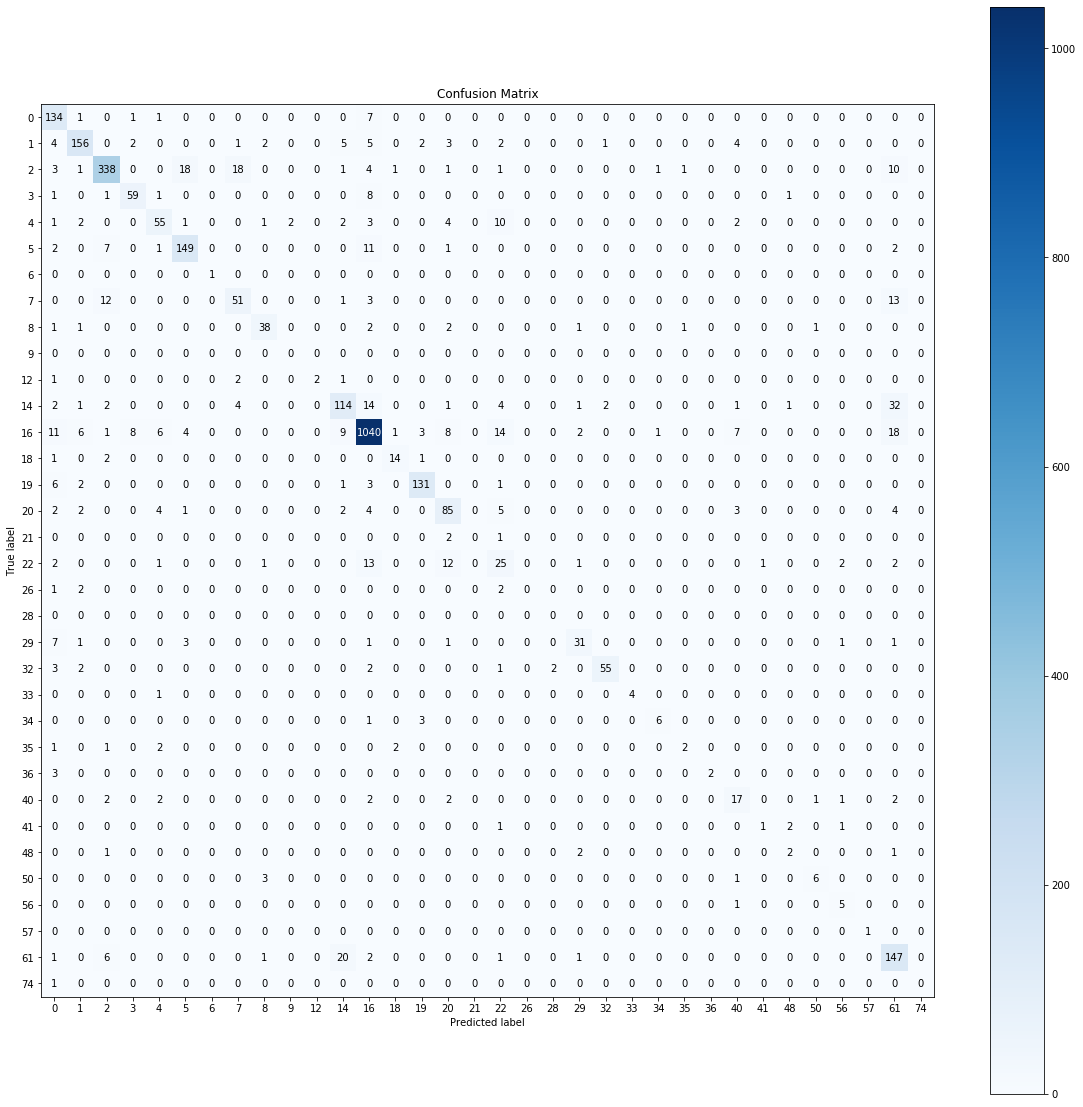

In [25]:
y_test3 = np.argmax(y_test, axis=1)
y_pred3 = np.argmax(y_pred3, axis=1)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
c = confusion_matrix(y_test3, y_pred3) 

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test3, 
    y_pred3,
    figsize=(20,20))

In [26]:
print(classification_report(y_test3, y_pred3, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.88      0.83      0.86       187
           2       0.91      0.85      0.88       398
           3       0.84      0.83      0.84        71

   micro avg       0.89      0.84      0.87       656
   macro avg       0.88      0.84      0.86       656
weighted avg       0.89      0.84      0.87       656



In [27]:
X_train_tfidf

<7527x1189 sparse matrix of type '<class 'numpy.float64'>'
	with 34397 stored elements in Compressed Sparse Row format>

# LogisticRegression

In [28]:
from sklearn.multiclass import OneVsRestClassifier
# Models
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(C=10, penalty='l1', dual=False, solver='liblinear')
model_lr = OneVsRestClassifier(model_lr)
model_lr.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [29]:
y_pred4 = model_lr.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(y_test,y_pred4)*100,"%")

accuracy :  68.31990080595163 %


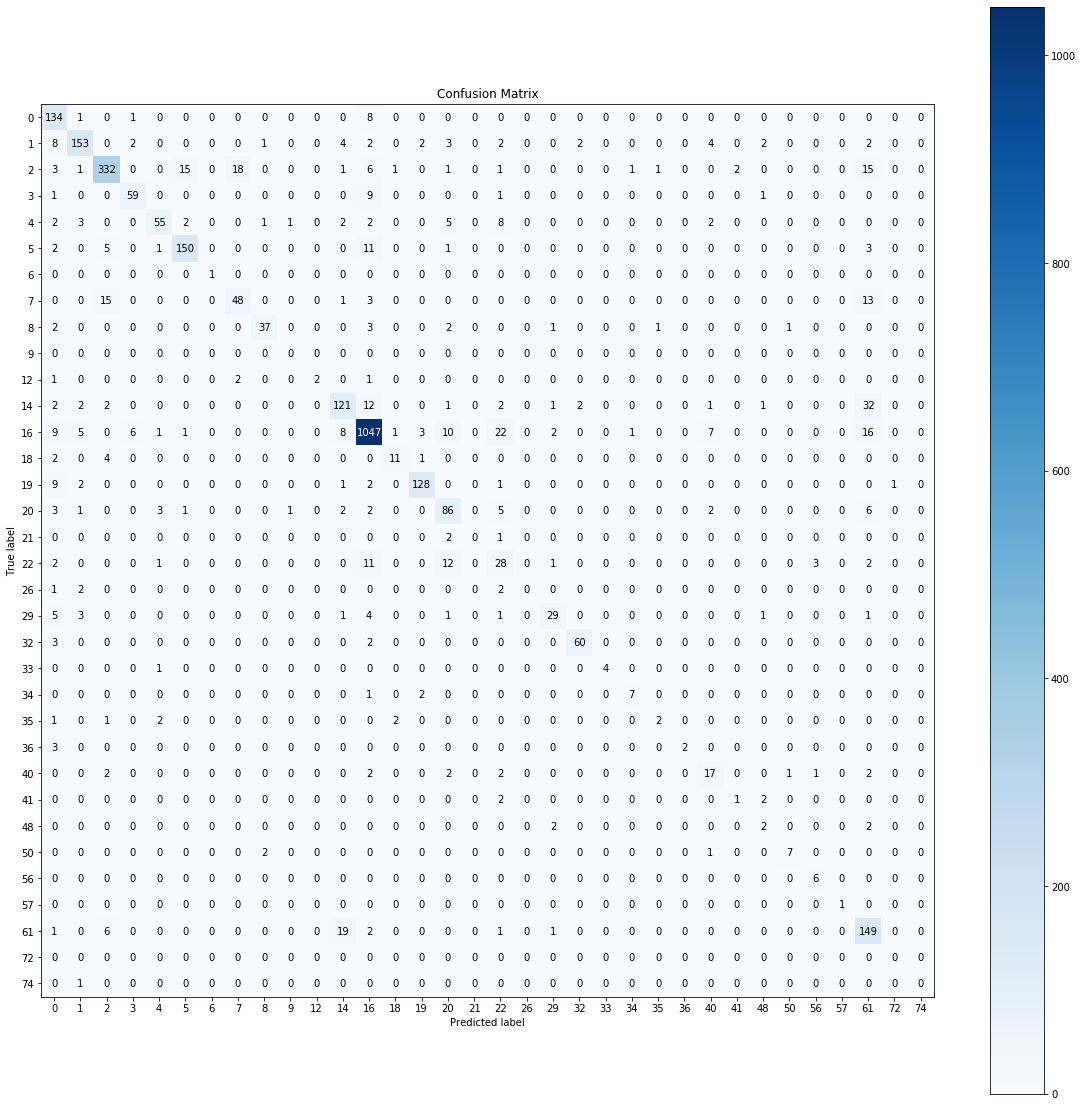

In [30]:
y_test4 = np.argmax(y_test, axis=1)
y_pred4 = np.argmax(y_pred4, axis=1)
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
c = confusion_matrix(y_test4, y_pred4) 

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test4, 
    y_pred4,
    figsize=(20,20))

In [31]:
print(classification_report(y_test4, y_pred4, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.88      0.82      0.85       187
           2       0.90      0.83      0.87       398
           3       0.87      0.83      0.85        71

   micro avg       0.89      0.83      0.86       656
   macro avg       0.88      0.83      0.85       656
weighted avg       0.89      0.83      0.86       656



# KNN


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import metrics
modelknn = neighbors.KNeighborsClassifier()
modelknn.fit(X_train_tfidf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [33]:
y_pred5 = modelknn.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score
print("accuracy : ",accuracy_score(y_test,y_pred5)*100,"%")

accuracy :  62.740235585864845 %


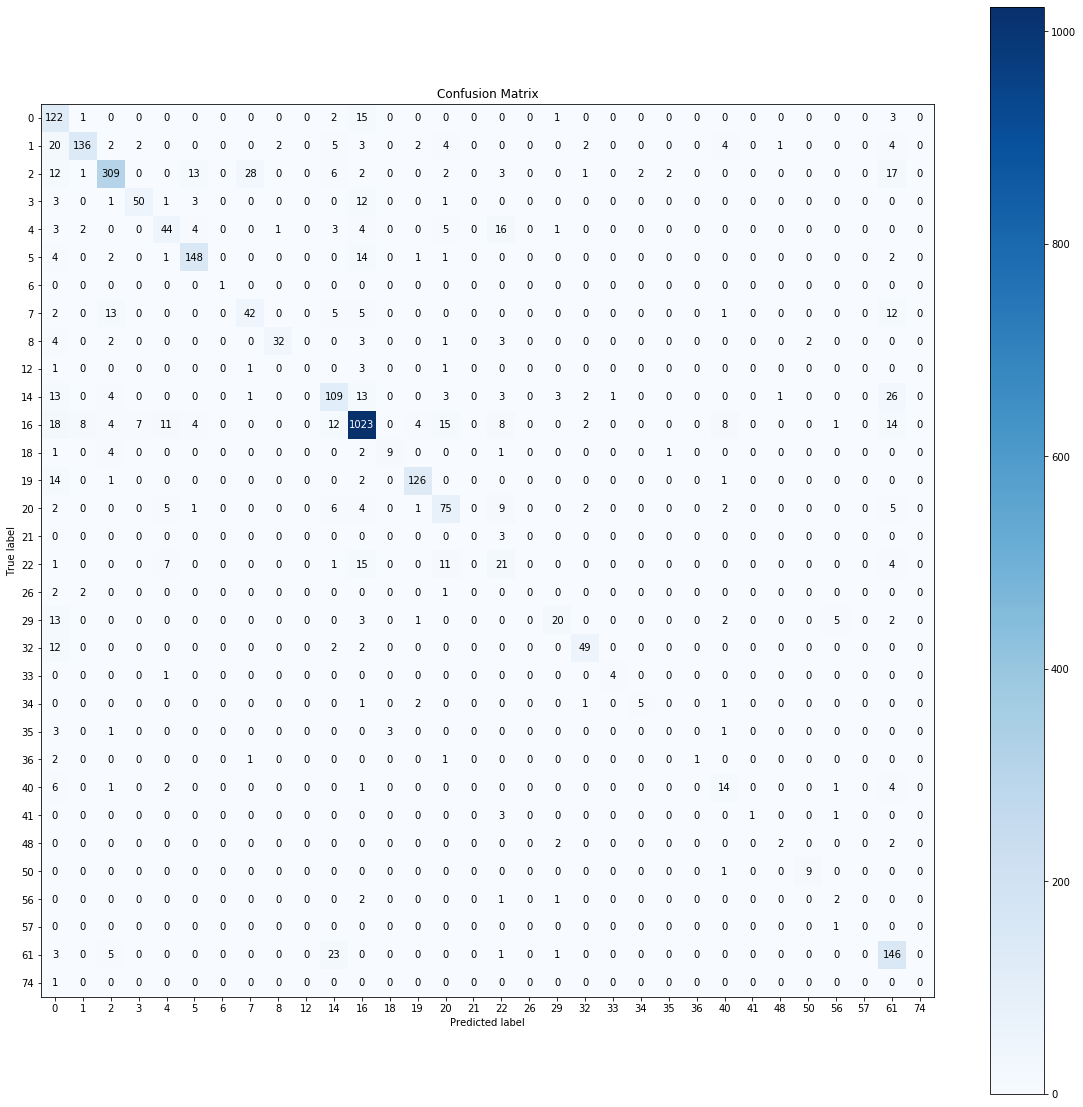

In [34]:
y_test5 = np.argmax(y_test, axis=1)
y_pred5 = np.argmax(y_pred5, axis=1) 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
cm = confusion_matrix(y_test5, y_pred5)
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test5, 
    y_pred5,
    figsize=(20,20))

In [35]:
print(classification_report(y_test5, y_pred5, labels=[1, 2, 3]))

              precision    recall  f1-score   support

           1       0.91      0.73      0.81       187
           2       0.89      0.78      0.83       398
           3       0.85      0.70      0.77        71

   micro avg       0.89      0.75      0.82       656
   macro avg       0.88      0.74      0.80       656
weighted avg       0.89      0.75      0.82       656



# Ensemble Learning ---- stacking

In [36]:
from scipy import stats
import sklearn.metrics as metrics
final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, stats.mode([y_pred4[i],
                                                   y_pred3[i], y_pred2[i]])[0][0])
y_test = np.argmax(y_test, axis=1)
print(metrics.accuracy_score(y_test, final_pred)*100,"%")

82.95102293862368 %
